In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

from sklearn.utils import shuffle
# device = torch.device("cuda")
torch.manual_seed(20210614)

import itertools
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model

from numpy.random import seed
seed(20210614)
import tensorflow
tensorflow.random.set_seed(20210614)

## Decide which Exp data set you want to use for generating data

In [2]:
#------- reading data from file for training, first Exp set
# df1 = pd.read_excel('RawData/Machine Learning Data_01.xlsx')

# df1.dropna(how='any', axis=1, inplace = True)
# # df1 = shuffle(df1, random_state=20210614)
# ###------- normalizing data 
# normalizer = MinMaxScaler()
# df_norm = normalizer.fit_transform(df1)

# train_data_length = 189  ##### Exp set 1 : 189, Both Expsets: 235 
# batch_size = 21          ##### Exp set 1 : 21, Both Expsets: 23

In [3]:

df_clean = pd.read_csv('RawData/NewData_cleaned.csv')
df_0 = pd.read_csv('RawData/ParametricStudy_0.csv')
df_1 = pd.read_csv('RawData/ParametricStudy_1_inv.csv')
df_2 = pd.read_csv('RawData/ParametricStudy_2_inv.csv')

# combined_Exp = df_clean
combined_Exp = pd.concat([df_clean, df_0, df_1, df_2], axis = 0, ignore_index = True)

combined_Exp = shuffle(combined_Exp, random_state=20210614)
print(combined_Exp.shape)

###------- normalizing data 
normalizer = MinMaxScaler()
df_norm = normalizer.fit_transform(combined_Exp)

# df_norm = pd.DataFrame(df, columns=combined_Exp.columns )

train_data_length = 200  ##### Exp set 2 : 203
batch_size = 25          ##### 

(203, 7)


In [4]:
# df_norm.astype(np.float32)

In [5]:
##------- reading data from file for training, first Exp set
# df1 = pd.read_excel('RawData/Machine Learning Data_01.xlsx')

# df1.dropna(how='any', axis=1, inplace = True)

# ############------- combining both Exp sets
# df2 = pd.read_csv('RawData/Exp_Set2_02.csv')

# combined_Exp = pd.concat([df1, df2], axis = 0, ignore_index = True)

# combined_Exp = shuffle(combined_Exp, random_state=20210614)
# print(combined_Exp.shape)

# ###------- normalizing data 
# normalizer = MinMaxScaler()
# df_norm = normalizer.fit_transform(combined_Exp)

# train_data_length = 230  ##### Exp set 1 : 189, Both Expsets: 230 
# batch_size = 23          ##### Exp set 1 : 21, Both Expsets: 23

In [4]:
train_data = torch.zeros((train_data_length, 7))   # 7 features must begenerated for each observation

###------- turn the traianing data to a torch tensor
train_data = torch.FloatTensor(df_norm.astype(np.float32))

train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]


In [5]:

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(7, 128),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            # nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            # nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 1),
            # nn.BatchNorm1d(1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output
    
discriminator = Discriminator()


In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(7, 16),
            # nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 32),
            # nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 7),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

In [8]:
lr_dis = 0.001
lr_gen = 0.0005
num_epochs = 6000

loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr_dis)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr_gen)

# optimizer_discriminator = torch.optim.SGD(discriminator.parameters(), lr=lr_dis, momentum=0.5)
# optimizer_generator = torch.optim.SGD(generator.parameters(), lr=lr_gen, momentum=0.5)

In [9]:
loss_disc = []
loss_gen = []
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        ## --- Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 7))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        ## --- Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        
        ## --- print(len(output_discriminator))
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        ## --- Data for training the generator
        latent_space_samples = torch.randn((batch_size, 7))

        ## --- Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        #Show loss
#         if epoch % 10 == 0 and n == batch_size - 1:
#         print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
#         print(f"Epoch: {epoch} Loss G.: {loss_generator}")
    if epoch % 10 == 0:
        loss_disc.append(loss_discriminator.item())
        loss_gen.append(loss_generator.item())

            

In [10]:
latent_space_samples = torch.randn(5000, 7)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()


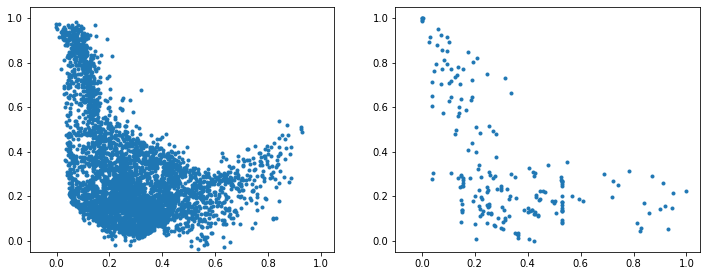

In [11]:

fig = plt.figure(figsize=(12,4.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(generated_samples[:, 5], generated_samples[:, 6], ".")
ax1.set_xlim(-0.1,1.05)
ax1.set_ylim(-0.05,1.05)
ax2.set_xlim(-0.1,1.05)
ax2.set_ylim(-0.05,1.05)
ax2.plot(train_data[:, 5], train_data[:, 6], ".")

plt.show()

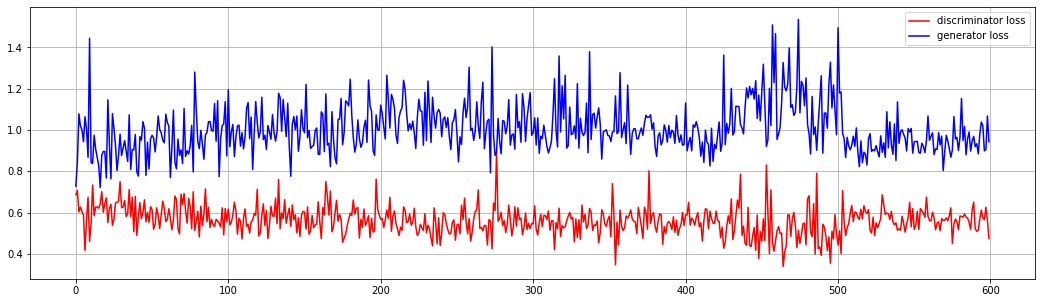

In [12]:
fig = plt.figure(figsize=(18,5))
plt.plot(loss_disc, 'r', label = 'discriminator loss')
plt.plot(loss_gen, 'b', label = 'generator loss')
# plt.xlim(250,300)
plt.legend()
plt.grid()
plt.show()

In [13]:
# def mse_old(y,ypred):
#     ### takes the real and predicted data and calcualtes the mean squared error
#     return np.mean((y-ypred)**2)


# def R2_old(y, predY):
#     ### takes the real and predicted data and returns the R^2 value
#     ### R2=0 => the model does nothing, 
#     ### R2=1 => the model is good as RSS=0,
#     ### R2<0 => the model is bad as RSS is too big  
#     res = y - predY  ### difference between the real and predicted values
#     RSS = sum(res**2)  
    
#     res_ave = y - np.mean(y)  ### if the model prediction was the same as mean of the data
#     TSS = sum(res_ave**2)     
    
#     return 1-RSS/TSS 

In [14]:
# def mse(y,ypred):
#     return (np.mean((y.ravel()-ypred.ravel())**2)*100).round(4)


# def R2(y, predY):
#     res = y.ravel() - predY.ravel() 
#     RSS = sum(res**2)  
    
#     res_vs_ave = y.ravel() - np.mean(y.ravel())  
#     TSS = sum(res_vs_ave**2)     
    
#     return ((1-RSS/TSS)*100).round(4) 

# Test the GAN data using
- Neural network
- 2nd order PN

When the models are trained
- with the original data and tested with GAN
- with GAN and tested with original data 


## Training Exp, Test GAN

In [15]:
### Two hidden layers Keras Tensor flow
def NN_twohidden(Xtrain, Y_train, Xtest, Y_test):
    
    tensorflow.random.set_seed(20210616)
    input = Input(shape=(Xtrain.shape[1],))
    # input = Input(shape=(5,))
    x = Dense(128, activation='relu')(input)
    x = Dense(64, activation='relu')(x)
    # x = Dense(32, activation='relu')(x)
    # x = Dense(16, activation='relu')(x)
    output = Dense(2)(x)
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer='adam', loss='mse')


    model.fit(Xtrain, (Y_train) , epochs=1000, batch_size=128 ,verbose=0)
    pred = model.predict(Xtest)

    error = (mean_squared_error(pred[:, 0], Y_test[:,0]), 
           mean_squared_error(pred[:, 1], Y_test[:,1]))
    print(f'NN test loss :{error}%')

    Rsquare = (r2_score(pred[:,0], Y_test[:,0])*100, 
             r2_score(pred[:,1], Y_test[:,1])*100)
    print(f'NN test R2 :{Rsquare}%')
    return pred

In [17]:
""" Exp, GAN """
df_scl = pd.DataFrame(df_norm, columns=combined_Exp.columns )

X_Exp = df_scl.drop(['Depth','Angle'], axis = 'columns')
Y_Exp = np.c_[df_scl.Depth, df_scl.Angle]

###------------------ 
df_GAN = pd.DataFrame(generated_samples.numpy(), columns=combined_Exp.columns )

X_GAN = df_GAN.drop(['Depth','Angle'], axis = 'columns')

Y_GAN = np.c_[df_GAN.Depth, df_GAN.Angle]

2021-09-22 14:49:33.153729: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-22 14:49:33.211912: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


NN test loss :(0.0027210199326730454, 0.020205561299077014)%
NN test R2 :(93.33277983096006, 61.79522799397935)%


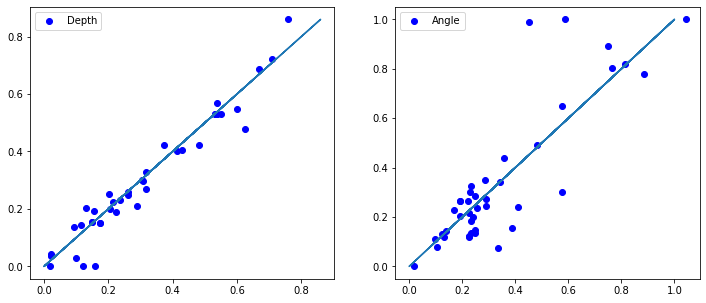

In [18]:
Xtrain, Xtest, Y_train, Y_test = train_test_split(X_Exp, Y_Exp,\
                                                  test_size = 0.20, random_state = 20210614)


pred = NN_twohidden(Xtrain, Y_train, Xtest, Y_test)
fig = plt.figure(figsize=(12,5))
# plt.subplots_adjust(wspace = 0.35)
# fig, ax = plt.subplots(dpi = 120, nrows = 1, ncols = 3, figsize = (10,6))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(pred[:, 0], Y_test[:,0], 'ob', label = 'Depth')
ax1.plot(Y_test[:,0], Y_test[:,0])
# print('Depth MSE, R2: ',mean_squared_error(pred[:, 0], Y_test[:,0]), r2_score(pred[:,0], Y_test[:,0])*100)

ax2.plot(pred[:, 1], Y_test[:,1], 'ob', label= 'Angle')
ax2.plot(Y_test[:,1], Y_test[:,1])
# print('Angle MSE, R2:',mean_squared_error(pred[:,1], Y_test[:,1]), r2_score(pred[:,1], Y_test[:,1])*100)

ax1.legend()
ax2.legend()
plt.show()

NN test loss :(0.0007182139, 0.0033706184)%
NN test R2 :(97.13079135377542, 92.29544294943892)%


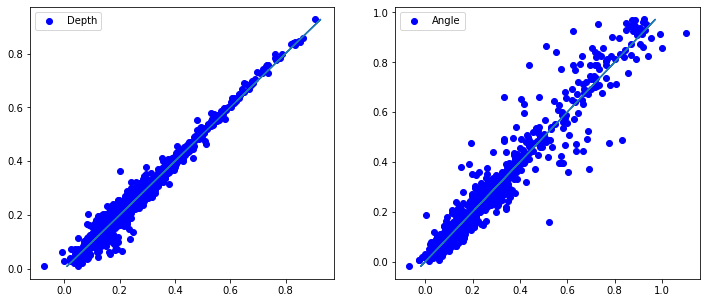

In [19]:
Xtrain, Xtest, Y_train, Y_test = train_test_split(X_GAN, Y_GAN,\
                                                  test_size = 0.20, random_state = 20210614)


pred = NN_twohidden(Xtrain, Y_train, Xtest, Y_test)
fig = plt.figure(figsize=(12,5))
# plt.subplots_adjust(wspace = 0.35)
# fig, ax = plt.subplots(dpi = 120, nrows = 1, ncols = 3, figsize = (10,6))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(pred[:, 0], Y_test[:,0], 'ob', label = 'Depth')
ax1.plot(Y_test[:,0], Y_test[:,0])
# print('Depth MSE, R2: ',mean_squared_error(pred[:, 0], Y_test[:,0]), r2_score(pred[:,0], Y_test[:,0])*100)

ax2.plot(pred[:, 1], Y_test[:,1], 'ob', label= 'Angle')
ax2.plot(Y_test[:,1], Y_test[:,1])
# print('Angle MSE, R2:',mean_squared_error(pred[:,1], Y_test[:,1]), r2_score(pred[:,1], Y_test[:,1])*100)

ax1.legend()
ax2.legend()
plt.show()

NN test loss :(0.004490425, 0.021410456)%
NN test R2 :(86.86034070429893, 58.92131030369854)%


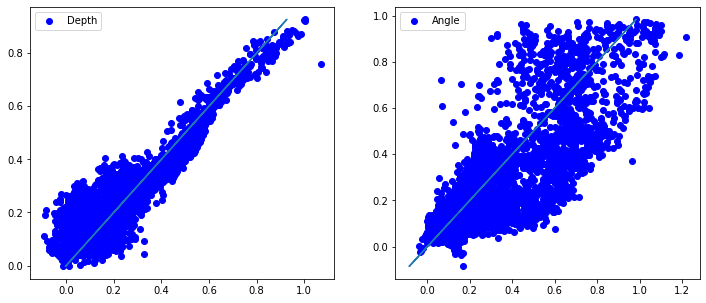

In [20]:
##### Train Exp, Tets GAN
Xtrain = X_Exp
Y_train = Y_Exp
Xtest = X_GAN
Y_test = Y_GAN
pred = NN_twohidden(Xtrain, Y_train, Xtest, Y_test)
fig = plt.figure(figsize=(12,5))
# plt.subplots_adjust(wspace = 0.35)
# fig, ax = plt.subplots(dpi = 120, nrows = 1, ncols = 3, figsize = (10,6))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(pred[:, 0], Y_test[:,0], 'ob', label = 'Depth')
ax1.plot(Y_test[:,0], Y_test[:,0])
# print('Depth MSE, R2: ',mean_squared_error(pred[:, 0], Y_test[:,0]), r2_score(pred[:,0], Y_test[:,0])*100)

ax2.plot(pred[:, 1], Y_test[:,1], 'ob', label= 'Angle')
ax2.plot(Y_test[:,1], Y_test[:,1])
# print('Angle MSE, R2:',mean_squared_error(pred[:,1], Y_test[:,1]), r2_score(pred[:,1], Y_test[:,1])*100)

ax1.legend()
ax2.legend()
plt.show()

NN test loss :(0.020239859450392864, 0.08554498018893476)%
NN test R2 :(68.53825319400242, 55.08537304920444)%


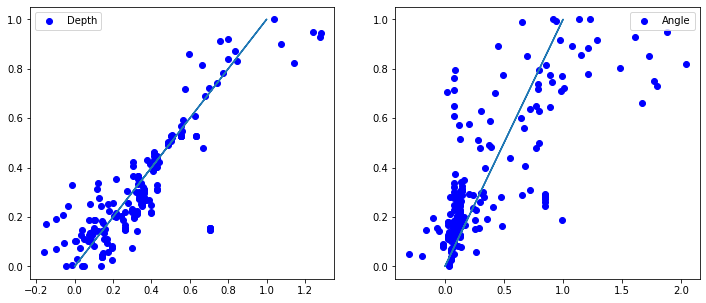

In [21]:
##### Train GAN, Tets Test
Xtrain = X_GAN
Y_train = Y_GAN
Xtest = X_Exp
Y_test = Y_Exp

pred = NN_twohidden(Xtrain, Y_train, Xtest, Y_test)
fig = plt.figure(figsize=(12,5))
# plt.subplots_adjust(wspace = 0.35)
# fig, ax = plt.subplots(dpi = 120, nrows = 1, ncols = 3, figsize = (10,6))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(pred[:, 0], Y_test[:,0], 'ob', label = 'Depth')
ax1.plot(Y_test[:,0], Y_test[:,0])
# print('Depth MSE, R2: ',mean_squared_error(pred[:, 0], Y_test[:,0]), r2_score(pred[:,0], Y_test[:,0])*100)

ax2.plot(pred[:, 1], Y_test[:,1], 'ob', label= 'Angle')
ax2.plot(Y_test[:,1], Y_test[:,1])
# print('Angle MSE, R2:',mean_squared_error(pred[:,1], Y_test[:,1]), r2_score(pred[:,1], Y_test[:,1])*100)

ax1.legend()
ax2.legend()
plt.show()

In [3]:
# def KerasNN(Xtrain, Y_train, Xtest, Y_test):
#   input = Input(shape=(5,))
#   hidden_layer_1 = Dense(128, activation='relu')(input)
#   output = Dense(Y_train.shape[1])(hidden_layer_1)

#   model = Model(inputs=input, outputs=output)
#   model.compile(
#       optimizer='adam',
#       loss=['mean_squared_error']
#       )
#   history = model.fit(Xtrain, Y_train, epochs=500, batch_size=8, verbose=0)

#   predict_9 = model.predict(Xtest)
#   error = (mse(Y_test[:,0], predict_9[:,0])+
#            mse(Y_test[:,1], predict_9[:,1]))/2 
#   print(f'NN test loss :{error}%')
#   Rsquare = (R2(Y_test[:,0], predict_9[:,0])+
#              R2(Y_test[:,1], predict_9[:,1]))/2
#   print(f'NN test R2 :{Rsquare}%')
#   return predict_9

In [18]:
# NNpred = KerasNN(Xtrain, Y_train, Xtest, Y_test)



2021-08-16 15:23:32.444582: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-16 15:23:32.496014: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


NN test loss :0.3375%
NN test R2 :81.98745%


In [19]:
# fig = plt.figure(figsize=(18,8))
# # plt.subplots_adjust(wspace = 0.5)
# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212)

# ax1.plot(Y_test[:50, 0], 'o-r', label = 'depth')
# ax1.plot(NNpred[:50, 0], color='b', label = 'NN_pred')

# ax2.plot(Y_test[:50, 1], 'o-r', label = 'angle')
# ax2.plot(NNpred[:50, 1], color='b', label = 'NN_pred')

# ax1.legend()
# ax2.legend()

# plt.show()

In [20]:
# model2 = Pipeline([
#     ('poly', PolynomialFeatures(degree=2, include_bias=False)),
#     ('linear_regression', LinearRegression())
# ])

In [21]:
# def PN(Xtrain, Y_train, Xtest, Y_test):
#   PN_model = model2.fit(Xtrain, Y_train)
#   PN_pred = PN_model.predict(Xtest)
#   error = (mse(Y_test[:,0], PN_pred[:,0])+
#        mse(Y_test[:,1], PN_pred[:,1]))/2 
#   print(f'PN test loss :{error}%')
#   Rsquare = (R2(Y_test[:,0], PN_pred[:,0])+
#          R2(Y_test[:,1], PN_pred[:,1]))/2
#   print(f'PN test R2 :{Rsquare}%')
#   return PN_pred

In [22]:
# PNpred = PN(Xtrain, Y_train, Xtest, Y_test)


In [23]:
# fig = plt.figure(figsize=(18,8))
# # plt.subplots_adjust(wspace = 0.5)
# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212)

# ax1.plot(Y_test[:50, 0], 'o-r', label = 'test depth')
# ax1.plot(PNpred[:50, 0], color='b', label = 'PN_pred')

# ax2.plot(Y_test[:50, 1], 'o-r', label = 'test angle')
# ax2.plot(PNpred[:50, 1], color='b', label = 'PN_pred')

# ax1.legend()
# ax2.legend()

# plt.show()

## Training GAN, Test Exp

In [24]:
# """ training: GAN, test:Exp """
# df_scl = pd.DataFrame(df_norm, columns=df1.columns )

# Xtest = df_scl.drop(['Depth','Angle'], axis = 'columns')
# Y_test = np.c_[df_scl.Depth, df_scl.Angle]

# ## -----------------
# df = pd.DataFrame(generated_samples.numpy(), columns=df1.columns )

# Xtrain = df.drop(['Depth','Angle'], axis = 'columns')

# Y_train = np.c_[df.Depth, df.Angle]

In [25]:
# NNpred = KerasNN(Xtrain, Y_train, Xtest, Y_test)

In [26]:
# fig = plt.figure(figsize=(18,8))
# # plt.subplots_adjust(wspace = 0.5)
# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212)

# ax1.plot(Y_test[:50, 0], 'o-r', label = 'depth')
# ax1.plot(NNpred[:50, 0], color='b')

# ax2.plot(Y_test[:50, 1], 'o-r', label = 'angle')
# ax2.plot(NNpred[:50, 1], color='b')

# ax1.legend()
# ax2.legend()

# plt.show()

In [27]:
# PNpred = PN(Xtrain, Y_train, Xtest, Y_test)

In [28]:
# fig = plt.figure(figsize=(18,8))
# # plt.subplots_adjust(wspace = 0.5)
# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212)

# ax1.plot(Y_test[:50, 0], 'o-r', label = 'test depth')
# ax1.plot(PNpred[:50, 0], color='b')

# ax2.plot(Y_test[:50, 1], 'o-r', label = 'test angle')
# ax2.plot(PNpred[:50, 1], color='b')

# ax1.legend()
# ax2.legend()

# plt.show()

In [29]:
"""Saving generated data in .csv file
We save the GAN data as well as their rescaled to original values """

# df.to_csv(r'RawData/GAN_02.csv', header=True, index = False)

### --------- At first we need to scale the Exp data used for GAN 
normalizer = MinMaxScaler()
df_norm = normalizer.fit_transform(combined_Exp)

unscl_Target1 = normalizer.inverse_transform(df)
unscl_target_df1 = pd.DataFrame(unscl_Target1.round(2), columns=df.columns )

# unscl_target_df1.to_csv(r'RawData/rscl_GAN_02.csv', header=True, index = False)
unscl_target_df1

,Frequency,Speed,Amplitude,Passes,Focal_Position,Depth,Angle
0,709.320007,20.139999,0.51,76.839996,93.199997,530.770020,51.110001
1,664.070007,16.230000,0.31,104.449997,93.849998,599.349976,30.850000
2,188.610001,4.670000,0.73,48.590000,93.199997,883.630005,35.570000
3,780.099976,18.980000,0.58,112.480003,93.199997,719.500000,41.150002
4,986.280029,12.370000,0.51,78.400002,93.199997,561.960022,46.340000
...,...,...,...,...,...,...,...
4995,304.269989,7.560000,1.66,20.690001,94.650002,242.949997,62.639999
4996,658.590027,11.400000,0.52,76.760002,93.199997,581.559998,48.400002
4997,476.750000,11.990000,0.95,19.059999,93.209999,474.470001,57.380001
4998,519.440002,14.800000,0.41,39.000000,94.440002,456.220001,53.860001


In [30]:
GAN_NNpred = np.c_[Xtest,NNpred]

# ### --------- At first we need to scale the Exp data used for GAN 
normalizer = MinMaxScaler()
df_norm = normalizer.fit_transform(combined_Exp)

unscl_Target2 = normalizer.inverse_transform(GAN_NNpred)
unscl_target_df2 = pd.DataFrame(unscl_Target2.round(2), columns=df.columns )

unscl_target_df2

# unscl_target_df2.to_csv(r'RawData/rscl_NNPred_GAN02.csv', header=True, index = False)

,Frequency,Speed,Amplitude,Passes,Focal_Position,Depth,Angle
0,709.320007,20.139999,0.51,76.839996,93.199997,610.409973,45.869999
1,664.070007,16.230000,0.31,104.449997,93.849998,564.469971,32.490002
2,188.610001,4.670000,0.73,48.590000,93.199997,1063.300049,34.279999
3,780.099976,18.980000,0.58,112.480003,93.199997,754.919983,41.560001
4,986.280029,12.370000,0.51,78.400002,93.199997,601.419983,48.200001
...,...,...,...,...,...,...,...
4995,304.269989,7.560000,1.66,20.690001,94.650002,378.040009,66.199997
4996,658.590027,11.400000,0.52,76.760002,93.199997,617.109985,49.770000
4997,476.750000,11.990000,0.95,19.059999,93.209999,408.299988,57.669998
4998,519.440002,14.800000,0.41,39.000000,94.440002,537.150024,48.939999


In [31]:
# """If we use the first Exp data set"""
# df.to_csv(r'RawData/GAN_01.csv', header=True, index = False)

# ### --------- At first we need to scale the Exp data used for GAN 
# normalizer = MinMaxScaler()
# df_norm = normalizer.fit_transform(df1)

# unscl_Target = normalizer.inverse_transform(df)
# unscl_target_df = pd.DataFrame(unscl_Target, columns=df.columns )

# unscl_target_df.to_csv(r'RawData/rscl_GAN_01.csv', header=True, index = False)

In [4]:
##------- reading data from file for training, first Exp set
df1 = pd.read_excel('RawData/Machine Learning Data_01.xlsx')

df1.dropna(how='any', axis=1, inplace = True)

############------- combining both Exp sets
df2 = pd.read_csv('RawData/Exp_Set2_02.csv')

combined_Exp = pd.concat([df1, df2], axis = 0, ignore_index = True)

# combined_Exp = shuffle(combined_Exp, random_state=20210614)
print(combined_Exp.shape)

###------- normalizing data 
normalizer = MinMaxScaler()
df_norm = normalizer.fit_transform(combined_Exp)
df_scl = pd.DataFrame(df_norm, columns=df1.columns )
Xtrain = df_scl.drop(['Depth', 'Angle'], axis = 'columns')
Y_train = np.c_[df_scl.Depth, df_scl.Angle]

###############

GAN = pd.read_csv(r'RawData/GAN_02_old.csv')
Xtest = GAN.drop(['Depth', 'Angle'], axis = 'columns')
Y_test = np.c_[GAN.Depth, GAN.Angle]

NNpred = KerasNN(Xtrain, Y_train, Xtest, Y_test)
GAN_NNpred = np.c_[Xtest, NNpred]

(235, 7)


2021-08-16 16:02:01.386254: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-16 16:02:01.439247: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


NN test loss :0.37825%
NN test R2 :78.9345%


In [5]:

################
normalizer = MinMaxScaler()
df_norm = normalizer.fit_transform(combined_Exp)

unscl_Target2 = normalizer.inverse_transform(GAN_NNpred)
unscl_target_df2 = pd.DataFrame(unscl_Target2.round(2), columns=df1.columns )
unscl_target_df2.to_csv(r'RawData/rscl_GAN_02_Aug16.csv', header=True, index = False)
unscl_target_df2

,Frequency,Speed,Amplitude,Passes,Focal_Position,Depth,Angle
0,623.87,17.19,0.52,83.84,93.20,593.23,46.51
1,781.66,20.40,0.57,41.97,93.74,685.47,35.61
2,602.61,15.80,0.65,49.04,93.20,660.14,49.22
3,726.26,18.07,0.57,55.82,93.86,684.28,40.34
4,273.51,7.27,0.68,21.84,93.20,654.78,42.29
...,...,...,...,...,...,...,...
4995,665.19,19.23,0.59,86.51,93.20,664.30,45.24
4996,875.69,22.42,0.44,115.09,93.93,538.75,44.86
4997,1351.47,31.19,0.54,79.86,93.20,498.28,56.85
4998,741.06,18.87,0.44,23.42,93.92,480.04,50.08


In [6]:
"""Unscaling"""
###############
normalizer = MinMaxScaler()
df_norm = normalizer.fit_transform(combined_Exp)

unscl_Target1 = normalizer.inverse_transform(GAN)
unscl_target_df1 = pd.DataFrame(unscl_Target1.round(2), columns=df1.columns )
unscl_target_df1.to_csv(r'RawData/rscl_PredGAN_02_Aug16.csv', header=True, index = False)
unscl_target_df1




,Frequency,Speed,Amplitude,Passes,Focal_Position,Depth,Angle
0,623.87,17.19,0.52,83.84,93.20,566.92,49.27
1,781.66,20.40,0.57,41.97,93.74,540.79,41.39
2,602.61,15.80,0.65,49.04,93.20,752.39,42.84
3,726.26,18.07,0.57,55.82,93.86,695.86,28.20
4,273.51,7.27,0.68,21.84,93.20,666.62,39.40
...,...,...,...,...,...,...,...
4995,665.19,19.23,0.59,86.51,93.20,813.16,41.99
4996,875.69,22.42,0.44,115.09,93.93,598.72,41.77
4997,1351.47,31.19,0.54,79.86,93.20,491.82,52.35
4998,741.06,18.87,0.44,23.42,93.92,461.89,42.41
